<a href="https://colab.research.google.com/github/AarohSinha100/DEEP_LEARNING/blob/main/Transfer_learning_tf_part2_FINETUNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine-tuning

In the previoud notebook we covered transfer learning - feature extraction. Not its the time to learn about a new type - Fine tuning

## Creating Helper functions

In previous notebooks we created a bunch of helper function, now we could rewrite it up but this is tedious (Now we will import the already written functions here that we wrote earlier)

> Getting the helper functions from mrdbourke -> github -> extras ->helperfuncs


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-19 05:58:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-19 05:58:45 (88.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we are going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **NOTE** IF you re running this notebook in Google Colab, when it times out colab will delete the heperfunctions.py so you will have to redownload it if you want to access to your helper functions

# Let's Get Some Data

This time we are going to see how we can use the pretrained model within tf.keras.applications (Keras Applications are premade architectures with pre-trained weights.) and apply them to our own problem (recognize the food)

In [ ]:
# Get 10% of trainig data of 10 classes of food101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip") #helper functions

--2023-05-19 05:58:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   248MB/s    in 0.6s    

2023-05-19 05:58:49 (248 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and sub directories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf


#Generates tf.data.Datasets
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


> What does the above function does?
* Create batches of 32 images of size 224x224 split into red,green,blue colour channels

In [ ]:
train_data_10_percent #This is a batchdataset (The above function has turned our data into batches)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
#Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of the batch of the data
for images ,labels in train_data_10_percent.take(1): #see data in '1' batch
  print(images,labels) #These are pixel values of our image labels (therse are 32 to diffrent examples in a batch)

tf.Tensor(
[[[[139.3015    150.11623   141.93097  ]
   [144.89972   153.7881    143.6765   ]
   [158.34232   162.63695   148.85794  ]
   ...
   [112.61128   124.6639    122.81124  ]
   [112.087364  125.37279   125.37279  ]
   [113.03427   127.03427   127.03427  ]]

  [[128.2862    139.91566   129.75685  ]
   [135.46143   144.34981   132.38106  ]
   [144.17761   148.47226   134.55644  ]
   ...
   [105.25951   115.53918   114.54668  ]
   [ 98.64285   110.64285   110.64285  ]
   [ 98.64285   110.64285   110.64285  ]]

  [[118.810745  128.09103   118.37133  ]
   [130.85715   137.74554   126.189735 ]
   [132.18048   136.3278    121.54878  ]
   ...
   [ 94.487915  105.00146   100.99239  ]
   [ 97.579544  107.36526   105.93669  ]
   [ 97.95758   106.5794    105.32542  ]]

  ...

  [[115.029     110.029      81.029    ]
   [114.33335   109.09518    80.214264 ]
   [113.70067   108.27214    79.486404 ]
   ...
   [ 62.255985   65.47699    56.403324 ]
   [ 51.650967   58.253857   48.190357 ]
   [ 

## Building a Feature Extraction Model using the Keras Functional API
> Model 0 :Building a Transfer Learning Feature Extraction Model using the keras Functional API
* The Sequential API is straight-forward, itruns layers in sequential order.
But the functional API gives us more flexibility with our models

In [ ]:
# 1.Create a nase model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False) #Include_top lets you select if you want the final dense layers or not.

# 2. Freeze the base model (so the underlying pre-trained patterns are'nt updated during the training)
base_model.trainable = False #This freezes the model (it doesnt gets trained)

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),
                               name="input_layer")

# 4. If using any models lik ResNet50V2 you will need to normalize inputs (This is optional You dont have to perform this in EfficientNet which have rescaling built in)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs) #Passing inout tensros in the base model
print(f"Shape after passing inputs in the base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with the outputs in the model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile fot the model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25 * len(test_data_10_percent)), #We will validate only on 25% of our validation data
                                 callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")]) #This function comes from helper function

16705208/16705208 [==============================] - 0s 0us/step


Shape after passing inputs in the base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230519-055858
Epoch 1/5
24/24 [==============================] - 21s 265ms/step - loss: 1.8708 - accuracy: 0.4107 - val_loss: 1.2857 - val_accuracy: 0.7253
Epoch 2/5
24/24 [==============================] - 5s 177ms/step - loss: 1.0890 - accuracy: 0.7667 - val_loss: 0.8489 - val_accuracy: 0.8289
Epoch 3/5
24/24 [==============================] - 4s 150ms/step - loss: 0.7814 - accuracy: 0.8280 - val_loss: 0.6784 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 5s 177ms/step - loss: 0.6315 - accuracy: 0.8667 - val_loss: 0.5688 - val_accuracy: 0.8684
Epoch 5/5
24/24 [==============================] - 4s 167ms/step - loss: 0.5381 - accuracy: 0.8760 - val_loss: 0.5479 - val_accuracy: 0.8487


##### Took only few seconds and we have a good Accuracy rate :)
* But as this is only on 25 percent of dataset it is not that believable.......lets now evaluate on full dataset

In [ ]:
#Evaluate on the full dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 72ms/step - loss: 0.5542 - accuracy: 0.8600


[0.5541728138923645, 0.8600000143051147]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
# How about we get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# How about summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


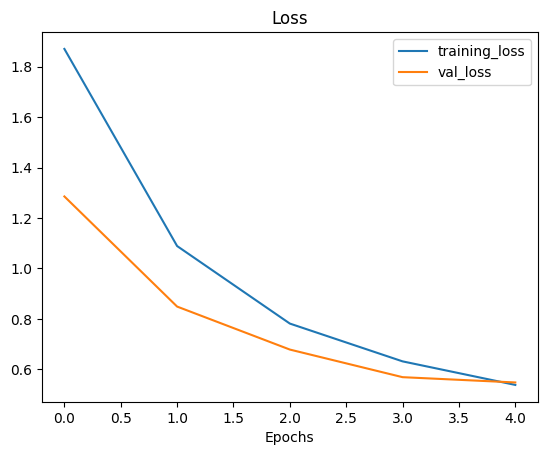

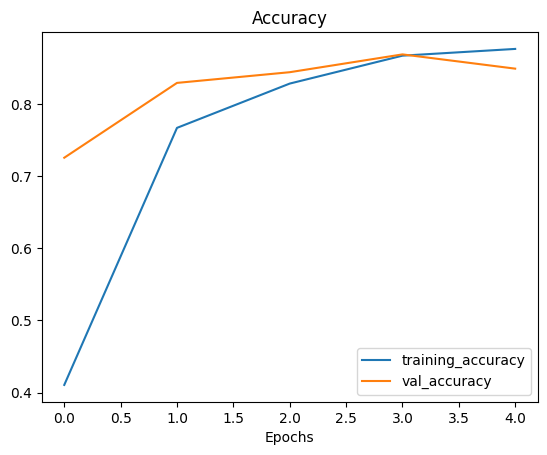

In [ ]:
# Check out our models trainng curves with the helper functions
plot_loss_curves(history_10_percent)

## Getting a Feature Vector From Our Trained Model

Let's demonstrate Global average pooling 2D layer

> we have a tensor after our model goes through base_model of shape (None, 7, 7, 1280).
>
>But when it passes through globalAveragePoolib2D it turns into (None,1280)

Let's use a similiar shaped tensor of (1, 4, 4,3) and then pass it to GlobalAveragePooling2D

In [ ]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor}\n")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [ ]:
# Pass the random tensor to GlobalAveragepooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor :\n {global_average_pooled_tensor}\n")

2D global average pooled random tensor :
 [[-0.09368646 -0.45840448 -0.2885598 ]]



#### GLOBALAVERAGEPOOLED LAYER - Condensed the input tensor into a smaller vector

It condenses it (It gets rid of 2 inner 4,4 dimensions). It converts the tensor to a feature vector

In [ ]:
#Check the shape of diffrent tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global averaged tensor: {global_average_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of global averaged tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
# Another kind of layer - GLOBAL MAXPOOL2D
global_maxpool2D_layer = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"The globalmaxpooled tensor: {global_maxpool2D_layer}")

The globalmaxpooled tensor: [[0.9058464 1.1603122 1.6994323]]


## Running a series ofTransfer Learning Experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of training data...how about we set up a few experiments to find out - 

1. `model_1` - using feature extraction transfer learning with 1 % of training data with data_augmentation.

2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation

3. `model_3` - use fine-tuning transfer learning on 100% of the training data with data augmentation

4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

## Getting and preprocessing data from MODEL 1

In [ ]:
# Download and unzip data - preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

#helper function
unzip_data("10_food_classes_1_percent.zip")

--2023-05-19 05:59:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 142.251.111.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   230MB/s    in 0.6s    

2023-05-19 05:59:53 (230 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with

#Helper function
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [ ]:
# Setup the data loaders

IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into the model, we can use the layers inside: 

* `tf.keras.layers.experimental.preprocessing()`

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms etc. (Augmentation only happens during training so we can export this model elsewhere)

# This is going to be a layer for our functional API
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) #Keep for models like ResNet50V2 but EffincientNet has inbuilt rescaling feature
], name="data_augmentation")


## Visualize our data augmentation image (and see what happens to our data)

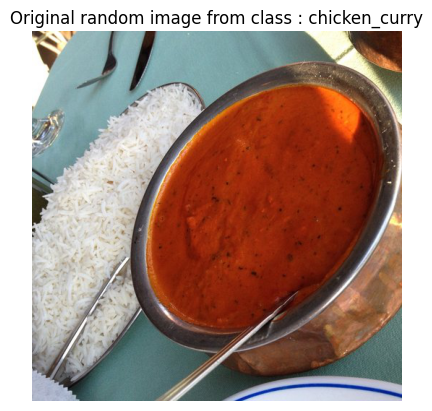

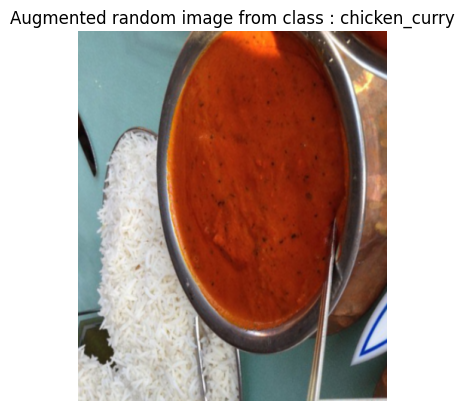

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image

# Read in random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class : {target_class}")
plt.axis(False);

# Now lets plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255)
plt.title(f"Augmented random image from class : {target_class}")
plt.axis(False);

## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [ ]:

# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230519-060000
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3298 - accuracy: 0.1000 - val_loss: 2.1815 - val_accuracy: 0.2188
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0644 - accuracy: 0.2714 - val_loss: 2.0442 - val_accuracy: 0.2977
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8782 - accuracy: 0.4286 - val_loss: 1.9381 - val_accuracy: 0.4013
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7452 - accuracy: 0.5429 - val_loss: 1.8357 - val_accuracy: 0.4622
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5870 - accuracy: 0.7286 - val_loss: 1.7535 - val_accuracy: 0.4951


Accuracy is not that good because we are using only 7 training images (but consider only these 7 images, it is good)

In [ ]:
# Check out our model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 68ms/step - loss: 1.7430 - accuracy: 0.4928


[1.7429931163787842, 0.4927999973297119]

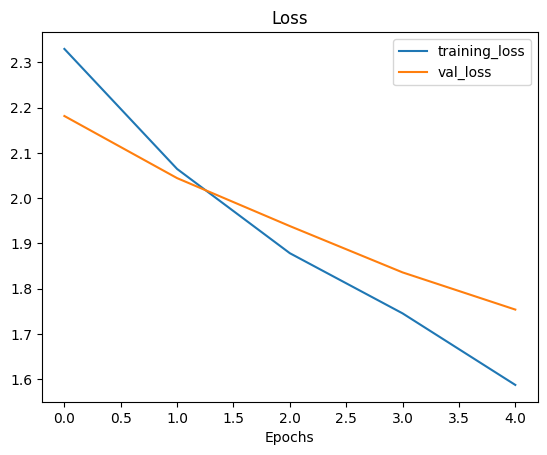

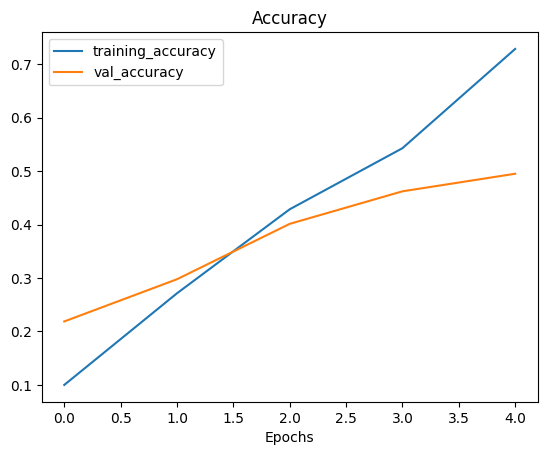

In [ ]:
# How does the model with 1 percent of the data and data augmentation loss curves look? 
plot_loss_curves(history_1_percent)

# Model 2: feature extraction transfer leaning model with 10% of data and data augmentation

In [ ]:
# Get 10% of data - we already have it!!
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:

# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


 # Build data augmentation layer
data_augmentation = Sequential([
   preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomRotation(0.2),
   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
 ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

### Creating A Model Checkpoint callback

The Model checkpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we ca ncomeback and start where we left offf.

In [ ]:
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Cerate a model checkpoint callback that saaves the models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", #save every epoch
                                                         verbose=1)

### Fit model2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data = test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                                                  checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230519-060054
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9672 - accuracy: 0.3653
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 23s 623ms/step - loss: 1.9672 - accuracy: 0.3653 - val_loss: 1.4672 - val_accuracy: 0.6447
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3090 - accuracy: 0.6933
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 13s 523ms/step - loss: 1.3090 - accuracy: 0.6933 - val_loss: 1.0061 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9843 - accuracy: 0.7720
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 12s 508ms/step - loss: 0.9843 - accuracy: 0.7720 - val_loss: 0.8213 - val_accuracy: 0.8076
Epoc

In [ ]:
#What were the model 0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 65ms/step - loss: 0.5542 - accuracy: 0.8600


[0.5541728138923645, 0.8600000143051147]

In [ ]:
#Check out model_2 results on all the test data 
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 78ms/step - loss: 0.6307 - accuracy: 0.8440


[0.6306650638580322, 0.843999981880188]

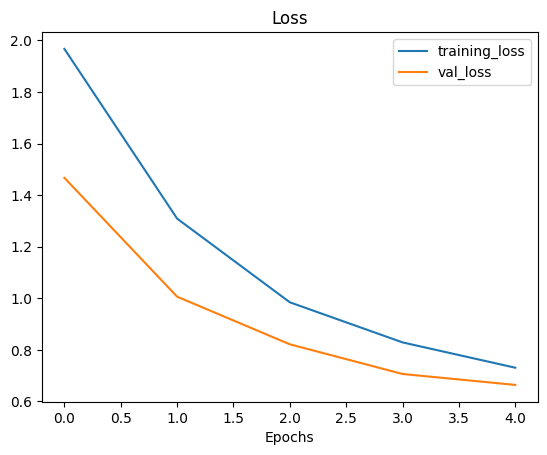

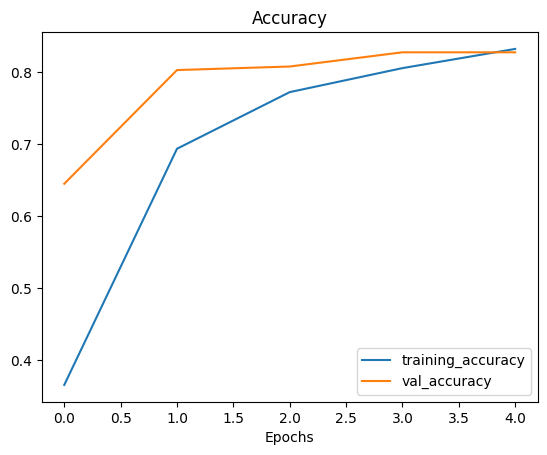

In [ ]:
#Plot model loss curves
plot_loss_curves(history_10_percent_data_aug) #Our model keeps on improving if we keep on training

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in save model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
#Evaluate model 2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.6307 - accuracy: 0.8440


In [ ]:
# If the results from our previously evaluated model 2 match from our loaded weights, everything worked!!
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.6306650638580322, 0.843999981880188]

In [ ]:
loaded_weights_model_results

[0.630665123462677, 0.843999981880188]

In [ ]:
### These nummbers are very close to each other
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results)) ## Yes they are very close

array([ True,  True])

In [ ]:
# Check the differnce between the two results
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10 percent of the data

> Note -  Fine Turning Usually works best after training a feature extraction model for a few epochs

In [ ]:
#### We are going to fine tune model 2 for a further 5 epochs

In [ ]:
# Layer in loaded model
model_2.layers

In [ ]:
# Are these layers trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1fa0bf0790> True
<keras.engine.sequential.Sequential object at 0x7f1fa0c387c0> True
<keras.engine.functional.Functional object at 0x7f1fa0a50af0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f1fa4f5ae00> True
<keras.layers.core.dense.Dense object at 0x7f1fa0929d50> True


In [ ]:
#What layers are in our base model (EfficientNetb0) and are they trainable?
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_5 False
2 normalization_2 False
3 rescaling_6 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# How many trainable variables in our base model?
print(len(model_2.layers[2].trainable_variables)) #Nothing in our base model
#We will make atleast 10 of them trainable

0


In [ ]:
#Last 10 layers
for layer in base_model.layers[len(base_model.layers)-10:]:
  print(layer.name)

block7a_se_squeeze
block7a_se_reshape
block7a_se_reduce
block7a_se_expand
block7a_se_excite
block7a_project_conv
block7a_project_bn
top_conv
top_bn
top_activation


**Note -** When using fine tuning its best practice by lowering the learning rate.

In [ ]:
# To begin fine tuning lets start by settting last 10 layers of our base_model.trainable = True
base_model.trainable = True

#Freeze all the layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False #for every layer except the last 10 gets freezed

# Recompile (we have to recompile our models everytime we make some change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), #General rule of fine tuning is to alter the learning rate (lets lower it by 10x)
                metrics=["accuracy"])

In [ ]:
#Check the layers which are tunable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_5 False
2 normalization_2 False
3 rescaling_6 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Now we have unfrozen some of the layers closer to the top, how many trainable parameters are there?
# ANS --> 12

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

#Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], #Start training from previous last epoch - it is gonna start fine tuning from the previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tuned_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tuned_last_10/20230519-060252


Epoch 5/10
24/24 [==============================] - 23s 496ms/step - loss: 0.7761 - accuracy: 0.7587 - val_loss: 0.4865 - val_accuracy: 0.8520
Epoch 6/10
24/24 [==============================] - 11s 427ms/step - loss: 0.3591 - accuracy: 0.8920 - val_loss: 0.4855 - val_accuracy: 0.8487
Epoch 7/10
24/24 [==============================] - 10s 415ms/step - loss: 0.2401 - accuracy: 0.9240 - val_loss: 0.4633 - val_accuracy: 0.8438
Epoch 8/10
24/24 [==============================] - 10s 377ms/step - loss: 0.1770 - accuracy: 0.9453 - val_loss: 0.4260 - val_accuracy: 0.8766
Epoch 9/10
24/24 [==============================] - 10s 404ms/step - loss: 0.1610 - accuracy: 0.9520 - val_loss: 0.4728 - val_accuracy: 0.8618
Epoch 10/10
13/24 [===============>..............] - ETA: 2s - loss: 0.0853 - accuracy: 0.9784

In [ ]:
# Evaluate the fine tuned model model (model_3 which is actually model_2 finetuned for another 5 epochs)
results_fine_tuned_10_percent = model_2.evaluate(test_data)

In [ ]:
results_10_percent_data_aug #before fine tuning

In [ ]:
#Check out the loss curves of our fine tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
# Let's create a function to compare one series of running fit with another (plot loss curves do good with models trained once)

In [ ]:

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
     

## Model 4 - Fine Tuning and existing model on all of the data



In [ ]:

# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-05-19 06:04:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 142.251.111.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  65.7MB/s    in 7.8s    

2023-05-19 06:04:21 (63.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)
     

In [ ]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)     

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)



Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we have been using in the previous experiments (all experiments use the same data)

Let's verify this....

In [ ]:
results_fine_tune_10_percent

79/79 [==============================] - 7s 79ms/step - loss: 0.4944 - accuracy: 0.8496


[0.4943546950817108, 0.8496000170707703]

In [ ]:
model_2.summary()

[0.49435463547706604, 0.8496000170707703]

In [ ]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
checkpoint_dir = "ten_percent_model_checkpoints_weights"
latest_weights = tf.train.latest_checkpoint(checkpoint_dir)

# Note: As of TensorFlow 2.10.0+, this may error, it should work with TensorFlow 2.9.0
# See the fix here: https://github.com/mrdbourke/tensorflow-deep-learning/issues/544
model_2.load_weights(latest_weights) # revert model back to saved weights

### We need to revert our model 2 back to feature extraction layer so that we can fine tune again

> To train a fine tuned model (model4) we need to revert it back to its feature extraction weights

In [ ]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 1- percent data model was fine tuned from
model_2.load_weights(tf.expand_dims(checkpoint_path))

TypeError: ignored

In [ ]:
#Lets evaluate model 2 now
